In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/utkface-new


In [ ]:
import os

print(os.listdir("/kaggle/input/utkface-new")[:10])  # show first 10 items


['UTKFace', 'utkface_aligned_cropped', 'crop_part1']


In [ ]:
DATASET_PATH = "/kaggle/input/utkface-new/UTKFace/"


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence

class UTKFaceGenerator(Sequence):
    def __init__(self, file_list, batch_size=64, img_size=(128,128)):
        self.file_list = file_list
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.file_list[idx * self.batch_size : (idx+1) * self.batch_size]
        images, ages, genders = [], [], []

        for img_name in batch_files:
            try:
                age, gender, *_ = img_name.split("_")
                age, gender = int(age), int(gender)

                img_path = os.path.join(DATASET_PATH, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, self.img_size)

                images.append(img / 255.0)
                ages.append(age)
                genders.append(gender)
            except:
                continue

        images = np.array(images, dtype="float32")
        ages = np.array(ages, dtype="float32")
        genders = np.array(genders, dtype="int")
        genders = np.eye(2)[genders]   # one-hot encode

        return images, {"age_output": ages, "gender_output": genders}


In [ ]:
from sklearn.model_selection import train_test_split

all_files = os.listdir(DATASET_PATH)
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)

train_gen = UTKFaceGenerator(train_files, batch_size=64)
test_gen = UTKFaceGenerator(test_files, batch_size=64)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization

# Input image (128x128 RGB)
input_layer = Input(shape=(128, 128, 3))

# Convolutional backbone
x = Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
x = MaxPooling2D(pool_size=(2,2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

# Two outputs
age_output = Dense(1, activation="linear", name="age_output")(x)          # Regression
gender_output = Dense(2, activation="softmax", name="gender_output")(x)  # Classification

# Define model
model = Model(inputs=input_layer, outputs=[age_output, gender_output])

# Compile model
model.compile(
    optimizer="adam",
    loss={"age_output": "mse", "gender_output": "categorical_crossentropy"},
    loss_weights={"age_output": 0.5, "gender_output": 0.5},
    metrics={"age_output": "mae", "gender_output": "accuracy"}
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32768)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  8,388,864 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 2)         │        514 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,483,779 (32.36 MB)

 Trainable params: 8,483,331 (32.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=30,   # increase if you have time
    verbose=1
)

# Save trained model
model.save("age_gender_model.h5")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 168s 536ms/step - age_output_loss: 387.7961 - age_output_mae: 14.4719 - gender_output_accuracy: 0.6225 - gender_output_loss: 3.4656 - loss: 195.6475 - val_age_output_loss: 288.1726 - val_age_output_mae: 12.5449 - val_gender_output_accuracy: 0.5502 - val_gender_output_loss: 1.0680 - val_loss: 141.8553
Epoch 2/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 44s 148ms/step - age_output_loss: 146.4675 - age_output_mae: 9.1612 - gender_output_accuracy: 0.6964 - gender_output_loss: 0.8115 - loss: 73.6442 - val_age_output_loss: 136.4453 - val_age_output_mae: 8.5635 - val_gender_output_accuracy: 0.7786 - val_gender_output_loss: 0.4699 - val_loss: 68.2612
Epoch 3/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 84s 156ms/step - age_output_loss: 120.2444 - age_output_mae: 8.3587 - gender_output_accuracy: 0.7157 - gender_output_loss: 0.6393 - loss: 60.4297 - val_age_output_loss: 216.1582 - val_age_output_mae: 11.9712 - val_gender_output_accuracy: 0.7229 - val_gender_output_loss: 0.5334 - v

In [ ]:
from google.colab import files
files.download("age_gender_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

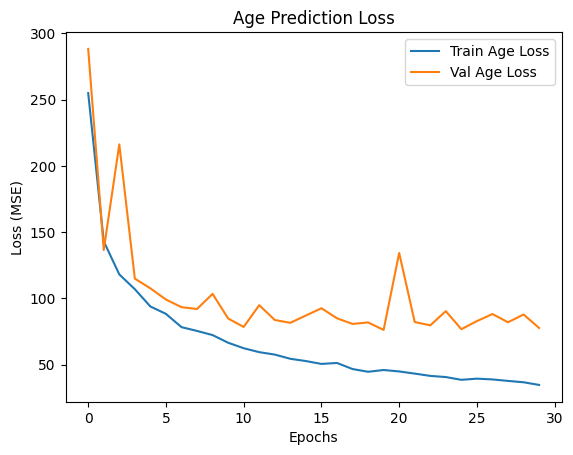

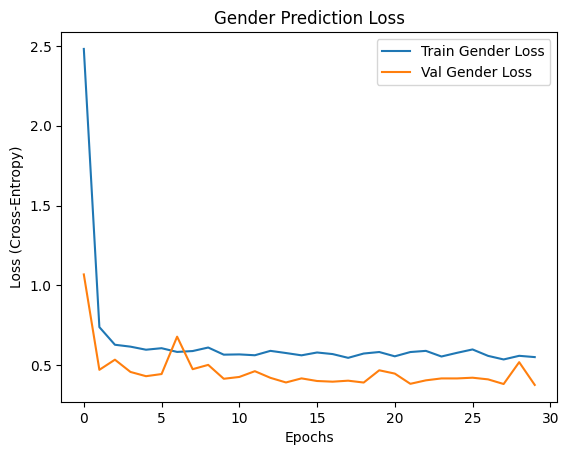

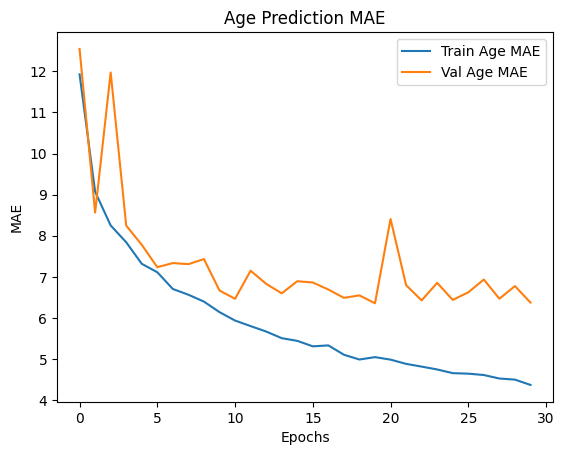

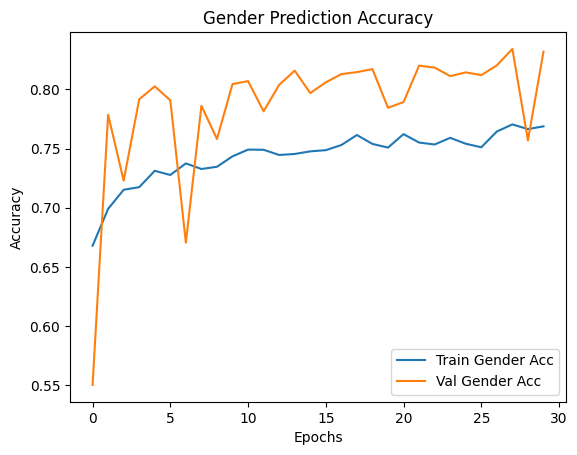

In [ ]:
import matplotlib.pyplot as plt

# Plot age loss
plt.plot(history.history['age_output_loss'], label='Train Age Loss')
plt.plot(history.history['val_age_output_loss'], label='Val Age Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Age Prediction Loss')
plt.show()

# Plot gender loss
plt.plot(history.history['gender_output_loss'], label='Train Gender Loss')
plt.plot(history.history['val_gender_output_loss'], label='Val Gender Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.title('Gender Prediction Loss')
plt.show()

# Plot age MAE
plt.plot(history.history['age_output_mae'], label='Train Age MAE')
plt.plot(history.history['val_age_output_mae'], label='Val Age MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Age Prediction MAE')
plt.show()

# Plot gender accuracy
plt.plot(history.history['gender_output_accuracy'], label='Train Gender Acc')
plt.plot(history.history['val_gender_output_accuracy'], label='Val Gender Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Gender Prediction Accuracy')
plt.show()


In [ ]:
import cv2
import numpy as np

def predict_age_gender(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)  # add batch dimension

    age_pred, gender_pred = model.predict(img)

    age = int(age_pred[0][0])
    gender = "Female" if np.argmax(gender_pred[0]) == 1 else "Male"

    return age, gender

# Example usage
test_img = "/content/old 3.jpg"
pred_age, pred_gender = predict_age_gender(test_img, model)
print(f"Predicted Age: {pred_age}, Gender: {pred_gender}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Predicted Age: 83, Gender: Female


In [ ]:
import os

DATASET_PATH = "/kaggle/input/utkface-new/UTKFace/"

# List some files from dataset
files = os.listdir(DATASET_PATH)
print("Sample files:", files[:5])  # check first 5 files


Sample files: ['26_0_2_20170104023102422.jpg.chip.jpg', '22_1_1_20170112233644761.jpg.chip.jpg', '21_1_3_20170105003215901.jpg.chip.jpg', '28_0_0_20170117180555824.jpg.chip.jpg', '17_1_4_20170103222931966.jpg.chip.jpg']


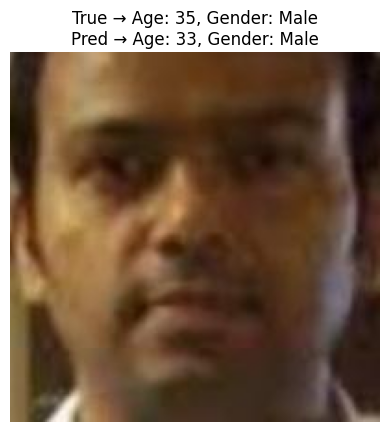

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_age_gender(img_path, model):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not load image at path: {img_path}")

    img = cv2.resize(img, (128, 128))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    age_pred, gender_pred = model.predict(img, verbose=0)

    age = int(age_pred[0][0])
    gender = "Female" if np.argmax(gender_pred[0]) == 1 else "Male"

    return age, gender

def show_prediction_with_truth(img_file, model, dataset_path):
    # Parse ground truth from filename
    age_true, gender_true, *_ = img_file.split("_")
    age_true = int(age_true)
    gender_true = "Female" if int(gender_true) == 1 else "Male"

    img_path = os.path.join(dataset_path, img_file)

    # Predict
    pred_age, pred_gender = predict_age_gender(img_path, model)

    # Show image + results
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True → Age: {age_true}, Gender: {gender_true}\n"
              f"Pred → Age: {pred_age}, Gender: {pred_gender}")
    plt.show()

# Example usage
DATASET_PATH = "/kaggle/input/utkface-new/UTKFace/"
files = os.listdir(DATASET_PATH)

# Test on the first file
show_prediction_with_truth(files[30], model, DATASET_PATH)
